In [1]:

import numpy as np
import tensorflow as tf
import keras
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

from keras.optimizers import Adam

from fully_conv_model_for_lidar import fcn_model
from util_func import *
from train_2 import *

from keras.utils.generic_utils import get_custom_objects
#loss = SSD_Loss(neg_pos_ratio=neg_pos_ratio, alpha=alpha)
get_custom_objects().update({"my_loss": my_loss})

import mayavi.mlab


Using TensorFlow backend.


# Load model

In [2]:

# CS's model
model = load_model('saved_model/cs_model_May_29_epoch_180.h5')

# Minh's model
# model = load_model('saved_model/model_May_29_450_76.h5')


[<tf.Tensor 'gradients/split_1_grad/concat:0' shape=(?, 64, 256, 8) dtype=float32>, None, None]


# Test prediction

In [3]:

def predict_boxes_(model, lidar, 
                   cluster=True, seg_thres=0.5, cluster_dist=0.1, min_dist=1.5, neigbor_thres=3,
                   ver_fov=(-24.4, 15.), v_res=0.42,
                   num_hor_seg=2, # only 2 or 4
                   merge_boxes=True,
                   visualize=False
                  ):
    all_view = []
    hor_fov_arr = []
    h_res = 0.0
    if num_hor_seg == 2:
        hor_fov_arr.append([-180.,0.])
        hor_fov_arr.append([0.,180.])
        h_res = 0.703125
    elif num_hor_seg == 4:
        hor_fov_arr.append([-180.,-90.])
        hor_fov_arr.append([-90.,0.])
        hor_fov_arr.append([0.,90.])
        hor_fov_arr.append([90.,180.])
        h_res = 0.3515625
        
    all_boxes = np.empty((0,8,3))
    
    for ns in range(num_hor_seg):
        view =  cylindrical_projection_for_test(lidar, hor_fov=hor_fov_arr[ns], h_res=h_res,
                                               ver_fov=ver_fov, v_res=v_res)
        if visualize:
            all_view.append(view)
        cylindrical_view = view[:,:,[5,2]].reshape(1,64,256,2)
        pred = model.predict(cylindrical_view)
        pred = pred[0]
        pred = pred.reshape(-1,8)
        view = view.reshape(-1,6)
        thres_pred = pred[pred[:,0] > seg_thres]
        thres_view = view[pred[:,0] > seg_thres]
        
        num_boxes = len(thres_pred)
        boxes = np.zeros((num_boxes,8,3))
        
        for i in range(num_boxes):
            boxes[i,0] = thres_view[i,:3] - rotation(thres_view[i,3],thres_pred[i,1:4])
            boxes[i,6] = thres_view[i,:3] - rotation(thres_view[i,3],thres_pred[i,4:7])

            boxes[i,2,:2] = boxes[i,6,:2]
            boxes[i,2,2] = boxes[i,0,2]

            phi = thres_pred[i,-1]

            z = boxes[i,2] - boxes[i,0]
            boxes[i,1,0] = (np.cos(phi)*z[0] + np.sin(phi)*z[1])*np.cos(phi) + boxes[i,0,0]
            boxes[i,1,1] = (-np.sin(phi)*z[0] + np.cos(phi)*z[1])*np.cos(phi) + boxes[i,0,1]
            boxes[i,1,2] = boxes[i,0,2]

            boxes[i,3] = boxes[i,0] + boxes[i,2] - boxes[i,1]
            boxes[i,4] = boxes[i,0] + boxes[i,6] - boxes[i,2]
            boxes[i,5] = boxes[i,1] + boxes[i,4] - boxes[i,0]
            boxes[i,7] = boxes[i,4] + boxes[i,6] - boxes[i,5]
        
        all_boxes = np.vstack((all_boxes, boxes))

    if not cluster:
        return all_boxes
    
    boxes_tmp = np.copy(all_boxes)

    flatteb_boxes = all_boxes.reshape(-1,24)
    num_box_total = len(all_boxes)
    box_dist = np.zeros((num_box_total, num_box_total))
    for i in range(num_box_total):
        box_dist[i] = np.sqrt(np.sum(np.square(flatteb_boxes[[i]] - flatteb_boxes), axis = 1))

    cluster_boxes = []

    thres_box_dist = box_dist < cluster_dist
    neighbor = np.sum(thres_box_dist, axis = 1)

    while len(neighbor)>0:

        ind = np.argmax(neighbor)

        if neighbor[ind] < neigbor_thres:
            break

        cluster_boxes.append(boxes_tmp[ind])

        remain_indx = box_dist[ind] > min_dist

        box_dist = box_dist[remain_indx]
        box_dist = box_dist[:,remain_indx]

        thres_box_dist = thres_box_dist[remain_indx]
        thres_box_dist = thres_box_dist[:,remain_indx]

        boxes_tmp = boxes_tmp[remain_indx]

        neighbor = np.sum(thres_box_dist, axis = 1)
    
    if visualize:
        fig, ax = plt.subplots(num_hor_seg,1, figsize = (24,15))
        for i in range(num_hor_seg):
            view = all_view[i]
            ax[i].imshow(view[:,:,5])
    
    return all_boxes, np.array(cluster_boxes) 


30827
317
2


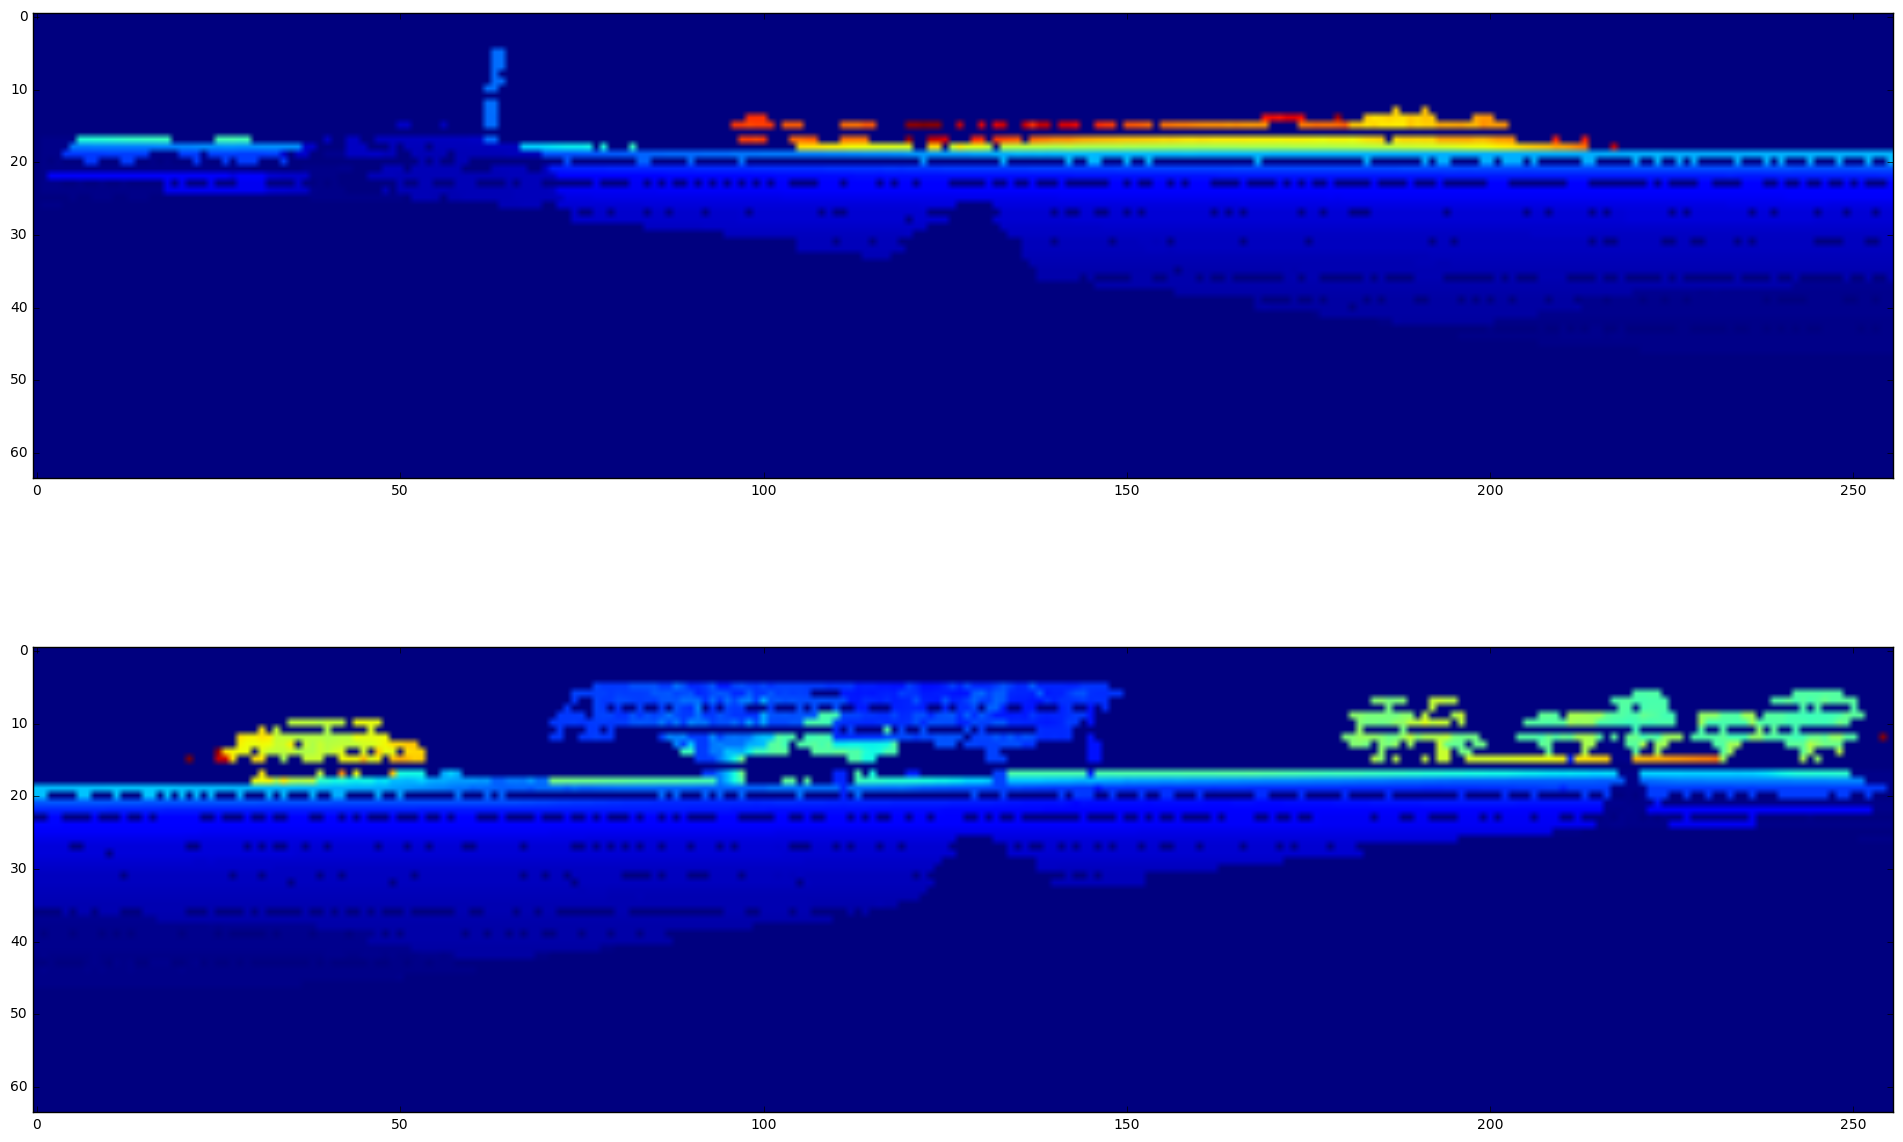

In [61]:

lidar = np.load('test_data/19_f2/lidar_270.npy')
print(len(lidar))

cluster_boxes = []
all_boxes = []

all_boxes, cluster_boxes = predict_boxes_(model, lidar, cluster = True,
                                            seg_thres=0.8, cluster_dist = 0.4, min_dist = 3., neigbor_thres = 3,
                                            ver_fov=(-24.4, 15.), v_res=1.,
                                            num_hor_seg=2, # only 2 or 4
                                            visualize=True)
print(len(all_boxes))
print(len(cluster_boxes))


# Visualize lidar points and bounding box, with ground truth tracklet (optional)

In [6]:

def viz_point_box_groundtruth(points, pred_boxes, gt_boxes, vals="distance"):
    x = points[:, 0]  # x position of point
    y = points[:, 1]  # y position of point
    z = points[:, 2]  # z position of pointfrom mpl_toolkits.mplot3d import Axes3D
    # r = lidar[:, 3]  # reflectance value of point
    d = np.sqrt(x ** 2 + y ** 2)  # Map Distance from sensor

    # Plot using mayavi -Much faster and smoother than matplotlib
    #import mayavi.mlab
    if vals == "height":
        col = z
    else:
        col = d

    fig = mayavi.mlab.figure(bgcolor=(0, 0, 0), size=(640, 360))
    mayavi.mlab.points3d(x, y, z,
                         col,          # Values used for Color
                         mode="point",
                         colormap='spectral', # 'bone', 'copper', 'gnuplot'
                         # color=(0, 1, 0),   # Used a fixed (r,g,b) instead
                         figure=fig,
                         )
    
    # predicted boxes
    pred_color = (1,1,1)
    for i in range(len(pred_boxes)):
        car = pred_boxes[i]
        x = car[:,0]
        y = car[:,1]
        z = car[:,2]

        mayavi.mlab.plot3d(x[:4], y[:4], z[:4], tube_radius=0.025, color=pred_color)#, colormap='Spectral')
        mayavi.mlab.plot3d(x[[0,3]], y[[0,3]], z[[0,3]], tube_radius=0.025, color=pred_color)
        mayavi.mlab.plot3d(x[[0,4]], y[[0,4]], z[[0,4]], tube_radius=0.025, color=pred_color)
        mayavi.mlab.plot3d(x[[1,5]], y[[1,5]], z[[1,5]], tube_radius=0.025, color=pred_color)
        mayavi.mlab.plot3d(x[[2,6]], y[[2,6]], z[[2,6]], tube_radius=0.025, color=pred_color)
        mayavi.mlab.plot3d(x[[3,7]], y[[3,7]], z[[3,7]], tube_radius=0.025, color=pred_color)
        
        mayavi.mlab.plot3d(x[-4:], y[-4:], z[-4:], tube_radius=0.025, color=pred_color)#, colormap='Spectral')
        mayavi.mlab.plot3d(x[[4,7]], y[[4,7]], z[[4,7]], tube_radius=0.025, color=pred_color)
    
    #ground truth boxes
    gt_color = (1,1,0)
    for i in range(len(gt_boxes)):
        car = gt_boxes[i]
        x = car[:,0]
        y = car[:,1]
        z = car[:,2]

        mayavi.mlab.plot3d(x[:4], y[:4], z[:4], tube_radius=0.025, color=gt_color)#, colormap='Spectral')
        mayavi.mlab.plot3d(x[[0,3]], y[[0,3]], z[[0,3]], tube_radius=0.025, color=gt_color)
        mayavi.mlab.plot3d(x[[0,4]], y[[0,4]], z[[0,4]], tube_radius=0.025, color=gt_color)
        mayavi.mlab.plot3d(x[[1,5]], y[[1,5]], z[[1,5]], tube_radius=0.025, color=gt_color)
        mayavi.mlab.plot3d(x[[2,6]], y[[2,6]], z[[2,6]], tube_radius=0.025, color=gt_color)
        mayavi.mlab.plot3d(x[[3,7]], y[[3,7]], z[[3,7]], tube_radius=0.025, color=gt_color)
        
        mayavi.mlab.plot3d(x[-4:], y[-4:], z[-4:], tube_radius=0.025, color=gt_color)#, colormap='Spectral')
        mayavi.mlab.plot3d(x[[4,7]], y[[4,7]], z[[4,7]], tube_radius=0.025, color=gt_color)
        
    mayavi.mlab.show()


In [62]:

viz_point_box_groundtruth(points=lidar, pred_boxes=cluster_boxes, gt_boxes=[])


# Generate tracklet file (Predict boxes from .npy files and save to .xml file)

In [ ]:

generate_tracklet(pred_model=model, input_folder='test_data/19_f2', output_file='test_data/round_1_tracklet.xml', \
                  fixed_size=None, # fixed box size: None or [l, w, h]
                  no_rotation=False, \
                  cluster=True, seg_thres=0.5, cluster_dist=0.7, min_dist=1.5, neigbor_thres=3)


# Check result

In [ ]:

from tracklet import *

def tracklet_test_to_boxes(filename, frame_number):
    all_tracklets = parse_xml(filename)
    
    frame_tracklets = []
    for i in range(len(all_tracklets)):
        if all_tracklets[i].first_frame == frame_number:
            frame_tracklets.append(all_tracklets[i])
    
    print("Num boxes in frame " + str(frame_number) + " : " + str(len(frame_tracklets)))
    
    frame_boxes = []
    for i in range(len(frame_tracklets)):
        t = frame_tracklets[i]
        h = t.size[2]
        w = t.size[1]
        l = t.size[0]
        bbox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [-h / 2, -h / 2, -h / 2, -h / 2, h / 2, h / 2, h / 2, h / 2],
        ])
        yaw = t.rots[0][2]
        rot_mat = np.array([
            [np.cos(yaw), -np.sin(yaw), 0.0],
            [np.sin(yaw), np.cos(yaw), 0.0],
            [0.0, 0.0, 1.0]
        ])
        position = t.trans[0]
        oriented_bbox = np.dot(rot_mat, bbox) + np.tile(position, (8, 1)).T
        t_box = oriented_bbox.T
        frame_boxes.append(t_box)
    return frame_boxes


In [ ]:

# get bounding box from udacity tracklet
# ground_truth_box = tracklet_gt_to_box('test_data/round_1_tracklet.xml', tracklet_idx=0, frame_number=239)
# print ground_truth_box
# print cluster_boxes[0]

# get bounding boxes from exported trcklet
imported_boxes = tracklet_test_to_boxes('test_data/round_1_tracklet.xml', frame_number=239)
print(imported_boxes)
print("and")
print(cluster_boxes)


In [ ]:

viz_point_box_groundtruth(points=lidar, pred_boxes=cluster_boxes, gt_boxes=imported_boxes)
